In [1]:
# Initial imports
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

In [2]:
# Set the random seed for reproducibility
# Note: This is used for model prototyping, but it is good practice to comment this out and run multiple experiments to evaluate your model.
from numpy.random import seed

seed(1)
from tensorflow import random

random.set_seed(2)

In [3]:
file_path = Path('~/Downloads/chart.csv')
punks_df = pd.read_csv(file_path, index_col= "Date", infer_datetime_format=True, parse_dates=True,)
punks_df.head()
punks_df.dropna(inplace=True)


In [4]:
punks_df

,Average USD
Date,
2017-06-23,53.70
2017-06-24,56.53
2017-06-25,52.43
2017-06-26,47.81
2017-06-27,52.96
...,...
2021-12-05,88463.56
2021-12-06,88925.25
2021-12-07,89066.04


In [5]:
def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [6]:
# Define the window size
window_size = 10 

# Set the index of the feature and target columns
feature_column = 0
target_column = 0

# Create the features (X) and target (y) data using the window_data() function.
X, y = window_data(punks_df, window_size, feature_column, target_column)

# Print a few sample values from X and y
print (f"X sample values:\n{X[:3]} \n")
print (f"y sample values:\n{y[:3]}")

X sample values:
[[ 53.7   56.53  52.43  47.81  52.96  56.9   57.05  59.98  73.79  76.76]
 [ 56.53  52.43  47.81  52.96  56.9   57.05  59.98  73.79  76.76  89.3 ]
 [ 52.43  47.81  52.96  56.9   57.05  59.98  73.79  76.76  89.3  115.  ]] 

y sample values:
[[ 89.3 ]
 [115.  ]
 [114.32]]


In [7]:
# Manually splitting the data
split = int(0.95 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [8]:
# Importing the MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the features data X
scaler.fit(X_train)

# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler object with the target data Y
scaler.fit(y_train)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [9]:
# Reshape the features data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print some sample data after reshaping the datasets
print (f"X_train sample values:\n{X_train[:3]} \n")
print (f"X_test sample values:\n{X_test[:3]}")

X_train sample values:
[[[8.75920702e-05]
  [1.29519518e-04]
  [6.84634925e-05]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]
  [0.00000000e+00]]

 [[1.29677904e-04]
  [6.86215796e-05]
  [0.00000000e+00]
  [7.57983963e-05]
  [5.78708889e-05]
  [2.19850604e-06]
  [4.28895432e-05]
  [2.01393010e-04]
  [4.23733287e-05]
  [1.78592130e-04]]

 [[6.87054948e-05]
  [0.00000000e+00]
  [7.63175295e-05]
  [1.33787849e-04]
  [6.00740953e-05]
  [4.51426574e-05]
  [2.45041281e-04]
  [2.44704902e-04]
  [2.21282939e-04]
  [5.44606304e-04]]] 

X_test sample values:
[[[1.00122287]
  [1.00230907]
  [1.00684887]
  [1.00212456]
  [1.00219586]
  [1.00127543]
  [1.00381029]
  [1.02235127]
  [1.00182006]
  [1.00017062]]

 [[1.00353476]
  [1.00917375]
  [1.00898798]
  [1.00432492]
  [1.00347402]
  [1.00509057]
  [1.02624577]
  [1.02421164]
  [1.00199098]
  [1.00194685]]

 [[1.01040784]
  [1.01131781]
  [1.01120341]
  [1.0056057 ]
  [1.00729731

In [10]:
# Importing required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [11]:
# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = 30
dropout_fraction = 0.5

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

2021-12-11 11:41:42.020499: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [13]:
# Show the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 30)            3840      
                                                                 
 dropout (Dropout)           (None, 10, 30)            0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 30)            7320      
                                                                 
 dropout_1 (Dropout)         (None, 10, 30)            0         
                                                                 
 lstm_2 (LSTM)               (None, 30)                7320      
                                                                 
 dropout_2 (Dropout)         (None, 30)                0         
                                                                 
 dense (Dense)               (None, 1)                 3

In [14]:
%%time
# Train the model
model.fit(X_train, y_train, epochs=20, shuffle=False, batch_size=30, verbose=1)

Epoch 1/20
52/52 [==============================] - 6s 14ms/step - loss: 0.0198
Epoch 2/20
52/52 [==============================] - 1s 13ms/step - loss: 0.0168
Epoch 3/20
52/52 [==============================] - 1s 14ms/step - loss: 0.0082
Epoch 4/20
52/52 [==============================] - 1s 13ms/step - loss: 0.0119
Epoch 5/20
52/52 [==============================] - 1s 12ms/step - loss: 0.0078
Epoch 6/20
52/52 [==============================] - 1s 12ms/step - loss: 0.0149
Epoch 7/20
52/52 [==============================] - 1s 12ms/step - loss: 0.0050
Epoch 8/20
52/52 [==============================] - 1s 11ms/step - loss: 0.0040
Epoch 9/20
52/52 [==============================] - 1s 12ms/step - loss: 0.0087
Epoch 10/20
52/52 [==============================] - 1s 12ms/step - loss: 0.0057
Epoch 11/20
52/52 [==============================] - 1s 11ms/step - loss: 0.0152
Epoch 12/20
52/52 [==============================] - 1s 11ms/step - loss: 0.0052
Epoch 13/20
52/52 [==================

In [15]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=0)

0.00334694585762918

In [16]:
# Make predictions using the testing data X_test
predicted = model.predict(X_test)

In [17]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [18]:
# Create a DataFrame of Real and Predicted values
nft = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = punks_df.index[-len(real_prices): ]) 

# Show the DataFrame's head
nft.head()

,Actual,Predicted
Date,,
2021-09-19,70429.32,69797.554688
2021-09-20,70568.11,70045.007812
2021-09-21,70699.26,70307.148438
2021-09-22,70832.27,70550.085938
2021-09-23,71146.69,70799.492188


<AxesSubplot:title={'center':'Actual Vs. Predicted Crypto Punk Prices'}, xlabel='Date'>

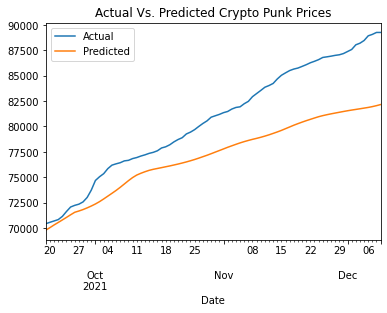

In [19]:
# Plot the real vs predicted prices as a line chart
nft.plot(title="Actual Vs. Predicted Crypto Punk Prices")
